In [1]:
%load_ext autoreload
%autoreload 2

# creacion del modelo de clasificacion

4. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo.
Siéntete libre de generar variables adicionales y/o complementar con variables externas.

5. Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué
elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la
performance?

### Métricas para evaluación de modelos con datos desbalanceados 

#### Efecto de datos desbalanceados

- El accuracy es engañosa

El rendimiento de los algoritmos de aprendizaje automático se evalúa normalmente mediante el accuracy. Sin embargo, esto no es apropiado cuando los datos están desbalanceados y/o los costos de los diferentes errores varían significativamente, dado que se puede obtener un acurracy bastante alto con sólo predecir la clase mayoritaria sin tomar en cuenta la clase minoritaria, que por lo regular suele ser el objetivo por el cuál se está realizando el modelo de clasificación.

Por ejemplo, se hace uso de un conjunto de datos que contiene transacciones hechas con tarjetas de credito en Europa en septiembre de 2013. Se está interesado en predecir si una persona incumplirá con el pago de su tarjeta. Se observa que de las 284807 transacciones registradas, sólo 492 corresponden a personas que incumplieron con el pago de su tarjeta (0.2 %), por lo que un modelo que clasifique todas las observaciones como no fraudulentas obtendría un accuracy igual a 99.8 %. Esta precisión sería alta simplemente porque la mayoría de las transacciones no son fraudulentas y no porque el modelo sea bueno.

- AUC ROC es demasiado optimista

La curva Receiver Operating Characteristics (ROC) y el área bajo la curva ROC (AUROC) se han convertido en la métrica más común para evaluar un modelo de clasificación.

El área bajo la curva (AUROC) es una métrica de rendimiento que se puede utilizar para evaluar modelos de clasificación. AUROC permite medir si un modelo puede clasificar correctamente los ejemplos. AUROC es una métrica de rendimiento para la “discriminación”: permite medir la capacidad del modelo para discriminar entre casos (ejemplos positivos) y no casos (ejemplos negativos). Un AUROC de 0.8 significa que el modelo tiene una buena capacidad de discriminación: 80 % de las ocasiones, el modelo asignará correctamente un riesgo absoluto más alto a un paciente seleccionado al azar con un evento que a un paciente seleccionado al azar sin un evento.

El peor AUROC es 0.5 y el mejor AUROC es 1.0.

Sin embargo, cuando la clase negativa es más frecuente pero hay un valor bajo en las predicciones negativas verdaderas esta metrica no presenta buenos resultados.

Por ejemplo, considere el caso de un conjunto de datos que tiene 10 positivos y 100000 negativos. Se dispone de 2 modelos:

Modelo A: predice 900 positivos, de los cuales 9 son verdaderos positivos Modelo B: predice 90 positivos, de los cuales 9 son verdaderos positivos

Obviamente, el Modelo B tiene un mejor rendimiento. Aunque ambos predicen el mismo número de positivos, el Modelo B no genera tantos falsos positivos. En otras palabras, el Modelo B es más “preciso”. Sin embargo, considere el análisis ROC de los dos modelos, que mide la tasa de verdaderos positivos (TPR) contra la tasa de falsos positivos
(FPR):

- Modelo A: TPR = 9/10 = 0.9 y FPR = (900–9) / 100,000 = 0.00891 Modelo B: TPR = 9/10 = 0.9 y FPR = (90–9) / 100,000 = 0.00081

Como era de esperar, TPR es exactamente el mismo entre ambos modelos. Por otro lado, dado que el número de negativos domina en gran medida al de positivos, la diferencia de FPR entre ambos modelos (0.00891-0.00081 = 0.0081) se pierde en el sentido de que se puede redondear a casi 0.

En otras palabras, un gran cambio en el número de falsos positivos resultó en un pequeño cambio en el FPR y, por lo tanto, la curva ROC no puede reflejar el desempeño superior del Modelo B en el contexto de que los verdaderos negativos no son relevantes para el problema.

- Precision-Recall

En contraste, la curva Precision-Recall (PR) está diseñada específicamente para la detección de eventos raros y es la métrica que debe usarse cuando la clase positiva es de más interés que la negativa.

Debido a que la precisión y la recall no consideran verdaderos negativos, la curva PR no se ve afectada por el desequilibrio de datos. Volviendo al ejemplo anterior:
Modelo A: Recall = TPR = 0.9 y Precision = 9/900 = 0.01 Modelo B: Recall = TPR = 0.9 y Precision = 9/90 = 0.1

Claramente, el análisis de PR es más informativo en comparación con el análisis de la curva ROC.

### Entrenamiento o Training del modelo de clasifiacion binario
Como sabemos nuestro dataset esta desbalanceado por este motivo recorreremos 3 caminos para seleccionar el mejor modelo
- entrenamiento con datos desbalanceados, posblemente tengamos un accuracy alto pero el PR de label 1(atraso) sean bajas
- entrenamiento con datos balanceados usando sub-muestreo, osea, igualar los labels eliminando datos de la clase con mas informacion, posiblemente tengamos un accuracy aceptable o bueno y un PR similar entre los labels.
- entrenamiento con datos balanceados usando sobre-muestreo, osea, igualar los labels aumentando los datos de la clase con menos informacion, posiblemente tengamos un accuracy aceptable o bueno y un PR similar entre los labels.

Para saber cuales serian las variables que mas pueden aporatar al modelo podemos hacer un test estadistico, Como la variable objetivo (y) es categórica, en lugar de utilizar un ANOVA para hacer una comparación de medias de las variables independientes, se puede utilizar un test estadístico para comparar la distribución de las variables independientes para cada categoría de la variable objetivo. Una opción popular es el test chi-cuadrado, que se puede calcular utilizando la función scipy.stats.chi2_contingency. Este test permite determinar si existe una asociación significativa entre la variable objetivo y cada una de las variables independientes.

In [49]:
# Importar las librerías necesarias
import latam_airlines.utils.paths as path
from latam_airlines.utils.latam_utils import modelPipeline, get_model_performance_test_set, save_simple_metrics_report, update_model

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, f1_score,precision_score,recall_score,accuracy_score, confusion_matrix

rs = {'random_state': 42}

In [50]:
# leemos el dataset de training
data_train = pd.read_csv(path.data_processed_dir('data_train.csv'))
data_train.sample(5)

,DIA,MES,AÑO,HORA,MIN,periodo_dia,DIANOM,MESNOM,Des_I,TIPOVUELO,OPERA,Vlo_change,Emp_change,temporada_alta,atraso_15
14888,19.0,3.0,2017.0,5,0,mañana,Domingo,Mar,SCAR,N,Sky Airline,0,0,0,0
54521,25.0,10.0,2017.0,14,35,tarde,Miercoles,Oct,SCFA,N,Grupo LATAM,0,0,0,0
67547,28.0,12.0,2017.0,19,45,noche,Jueves,Dic,SPJC,I,Grupo LATAM,1,1,1,0
54184,23.0,10.0,2017.0,20,25,noche,Lunes,Oct,SCFA,N,Grupo LATAM,0,1,0,0
54036,23.0,10.0,2017.0,6,45,mañana,Lunes,Oct,SBGR,I,Grupo LATAM,0,0,0,0


In [51]:
cols = data_train.drop('atraso_15', axis=1).columns
for col in cols:
    if col in ['DIA','MES','AÑO', 'HORA','MIN']:
        data_train[col] = data_train[col].astype(int).astype(str)
    else:
        data_train[col] = data_train[col].astype(str)

In [52]:
from scipy.stats import chi2_contingency

p_value = []
cols = data_train.drop('atraso_15', axis=1).columns
for col in cols:
    # Crea las tablas de contingencia para cada variable independiente
    contingency_table_1 = pd.crosstab(data_train['atraso_15'], data_train[col])

    # Realiza la prueba de chi-cuadrado para cada tabla de contingencia
    chi2, p_value_1, dof, expected_values_1 = chi2_contingency(contingency_table_1)
    if p_value_1< 0.05:
        p_value.append({col:p_value_1})
        # Imprime los resultados
        print(f'P-value variable {col}: {p_value_1}')

P-value variable DIA: 7.867393993266961e-31
P-value variable MES: 2.1517193601842396e-246
P-value variable HORA: 3.8935697385017177e-94
P-value variable MIN: 2.5598923720983557e-65
P-value variable periodo_dia: 6.517629986484475e-37
P-value variable DIANOM: 2.5667635629976846e-44
P-value variable MESNOM: 2.151719360183995e-246
P-value variable Des_I: 0.0
P-value variable TIPOVUELO: 7.639241830438933e-139
P-value variable OPERA: 0.0
P-value variable Vlo_change: 9.710470204938671e-36
P-value variable Emp_change: 0.04486985938729138
P-value variable temporada_alta: 5.1905227983983924e-08


Como resultados observamos que las variables escogidas son importante para poder predecir el atraso y nos aportan informacion relevante, a excepcion del anio, que no supero el test

In [53]:
data_train.drop(columns='AÑO', inplace=True)
data_train.head(5)

,DIA,MES,HORA,MIN,periodo_dia,DIANOM,MESNOM,Des_I,TIPOVUELO,OPERA,Vlo_change,Emp_change,temporada_alta,atraso_15
0,1,1,0,15,noche,Domingo,Ene,MMMX,I,Aeromexico,0,0,1,0
1,1,1,1,15,noche,Domingo,Ene,SKBO,I,Grupo LATAM,0,0,1,0
2,1,1,1,23,noche,Domingo,Ene,MPTO,I,Copa Air,0,0,1,0
3,1,1,1,33,noche,Domingo,Ene,SKBO,I,Avianca,0,0,1,0
4,1,1,1,42,noche,Domingo,Ene,MPTO,I,Copa Air,0,0,1,0


In [54]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68146 entries, 0 to 68145
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DIA             68146 non-null  object
 1   MES             68146 non-null  object
 2   HORA            68146 non-null  object
 3   MIN             68146 non-null  object
 4   periodo_dia     68146 non-null  object
 5   DIANOM          68146 non-null  object
 6   MESNOM          68146 non-null  object
 7   Des_I           68146 non-null  object
 8   TIPOVUELO       68146 non-null  object
 9   OPERA           68146 non-null  object
 10  Vlo_change      68146 non-null  object
 11  Emp_change      68146 non-null  object
 12  temporada_alta  68146 non-null  object
 13  atraso_15       68146 non-null  int64 
dtypes: int64(1), object(13)
memory usage: 7.3+ MB


In [55]:
#Seleccionar la columnas importantes
col_order = ['DIA', 'MES', 'HORA', 'MIN','Vlo_change', 'Emp_change','temporada_alta','periodo_dia','DIANOM', 'MESNOM','Des_I', 'TIPOVUELO', 'OPERA','atraso_15']
data_train = data_train[col_order]
# Exportar las columnas adicionales a un archivo .csv
data_train.to_csv(path.data_processed_dir('data_train.csv'), index=False)

## Camino 1 - sin balancear el dataset

In [56]:
# leemos el dataset de training
data_train = pd.read_csv(path.data_processed_dir('data_train.csv'))

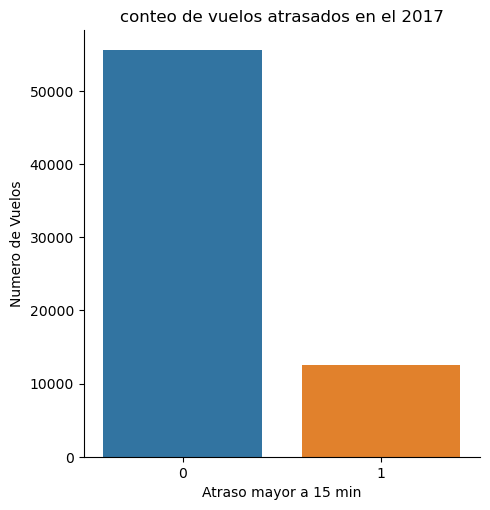

In [57]:
sns.catplot(
    data= data_train,
    x='atraso_15',
    kind='count',
)
plt.xlabel('Atraso mayor a 15 min')
plt.ylabel('Numero de Vuelos')
plt.title('conteo de vuelos atrasados en el 2017')
plt.show()

In [58]:
# Dividir los datos en variables de entrada y salida
X = data_train.drop('atraso_15', axis=1)
y = data_train['atraso_15']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [59]:
# entrenamos y evaluamos diferentes modelos
pipelines, scores_df = modelPipeline(X_train, X_test, y_train, y_test)
scores_df

/home/frandak2/latam_airlines/latam_airlines/utils/latam_utils.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({
/home/frandak2/latam_airlines/latam_airlines/utils/latam_utils.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({
/home/frandak2/latam_airlines/latam_airlines/utils/latam_utils.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({
/home/frandak2/latam_airlines/latam_airlines/utils/latam_utils.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({
/home/frandak2/latam_airlines/latam_airlines/utils/l

,Model,F1_Score,Precision,Recall,Accuracy
0,Logistic Regression,0.755422,0.780123,0.822002,0.822002
1,MLP,0.779200,0.772540,0.787664,0.787664
2,Decision Tree,0.749352,0.753669,0.745353,0.745353
3,Random Forest,0.784420,0.775943,0.812512,0.812512
4,XGBoost,0.789873,0.803723,0.832078,0.832078


Esta tabla muestra los resultados de 5 modelos diferentes de ML en un problema de clasificación. Las métricas incluyen F1 Score, Precision, Recall y Accuracy. Estas métricas permiten evaluar la capacidad de los modelos para clasificar correctamente las etiquetas de la clase objetivo. 
- F1 Score es una métrica combinada de Precision y Recall. 
- Precision mide la cantidad de etiquetas positivas correctas en comparación con las etiquetas positivas totales predichas. osea, la capacidad del modelo de clasificar realmente si un vuelo se atraso 
- Recall mide la cantidad de etiquetas positivas correctas en comparación con las etiquetas positivas totales reales. osea, el acierto del modelo para clasificar un vuelo con o sin retraso en la realidad
- Accuracy mide la proporción de etiquetas clasificadas correctamente. Esta metrica puede ser enganosa, hay que ver muy bien como se comporta la matriz de confusion

Para la selelcion del modelo tomaremos el modelo que presente mejore metricas.

In [60]:
# Crear una pipeline que incluya el ColumnTransformer y el RandomForestClassifier
# Crear un objeto ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler( with_mean=False), ['DIA', 'MES', 'HORA', 'MIN','Vlo_change', 'Emp_change','temporada_alta']),
        ('cat-nominal', OneHotEncoder(), ['periodo_dia','DIANOM', 'MESNOM','Des_I', 'TIPOVUELO', 'OPERA'])
    ],
    )
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',XGBClassifier(**rs))
    ]
)

In [61]:
# realizar validacion cruzada
final_result = cross_validate(pipe, X_train, y_train, return_train_score=True, cv=5)
#observamos la dispersion del score
train_score_std = np.std(final_result['train_score'])
test_score_std = np.std(final_result['test_score'])
print('Dispersion del score en la validacion cruzada')
print(f'Dispersion train score: {train_score_std}')
print(f'Dispersion test score: {test_score_std}')

# Observamos la media del score
train_score_mean = np.mean(final_result['train_score'])
test_score_mean = np.mean(final_result['test_score'])
print('media del score en la validacion cruzada')
print(f'media train score: {train_score_mean}')
print(f'media test score: {test_score_mean}')

# Entrenar modelo
pipe.fit(X_train, y_train)
# Mostrar los resultados

validation_score =pipe.score(X_test, y_test)

y_pred = pipe.predict(X_test)

# Imprimiendo el reporte de clasificación
report = classification_report(y_test, y_pred)
print(report)

Dispersion del score en la validacion cruzada
Dispersion train score: 0.00012551069914364303
Dispersion test score: 0.0010078741350982613
media del score en la validacion cruzada
media train score: 0.8463062345690371
media test score: 0.824242135398436
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     16759
           1       0.63      0.17      0.27      3685

    accuracy                           0.83     20444
   macro avg       0.73      0.57      0.59     20444
weighted avg       0.80      0.83      0.79     20444



Se puede concluir lo siguiente:

- Para la clase 0 (no atraso), el modelo tiene una precision de 0.84, lo que significa que el 84% de los casos clasificados como no atrasados son realmente no atrasados.
- Para la clase 0 (no atraso), el modelo tiene un recall de 0.98, lo que significa que el 98% de los casos reales de no atraso son identificados correctamente por el modelo.
- Para la clase 0 (no atraso), el modelo tiene un f1-score de 0.91, lo que indica un buen desempeño en la clasificación de la clase 0.
- Para la clase 1 (atraso), el modelo tiene una precision de 0.63, lo que significa que solo el 63% de los casos clasificados como atrasados son realmente atrasados.
- Para la clase 1 (atraso), el modelo tiene un recall de 0.17, lo que significa que solo el 17% de los casos reales de atraso son identificados correctamente por el modelo.
- Para la clase 1 (atraso), el modelo tiene un f1-score de 0.27, lo que indica un mal desempeño en la clasificación de la clase 1.
- El accuracy general del modelo es de 0.83, lo que significa que el modelo predice correctamente el 83% de las veces en promedio.

Es importante considerar tanto la precision como el recall para la clase minoritaria (atraso), ya que un modelo con una precision alta pero un recall bajo no será útil si se desea detectar todos los casos de atraso. En este caso, se podría considerar la re-calibración del modelo o la utilización de técnicas de balanceo de datos para mejorar su desempeño en la clasificación de la clase minoritaria.

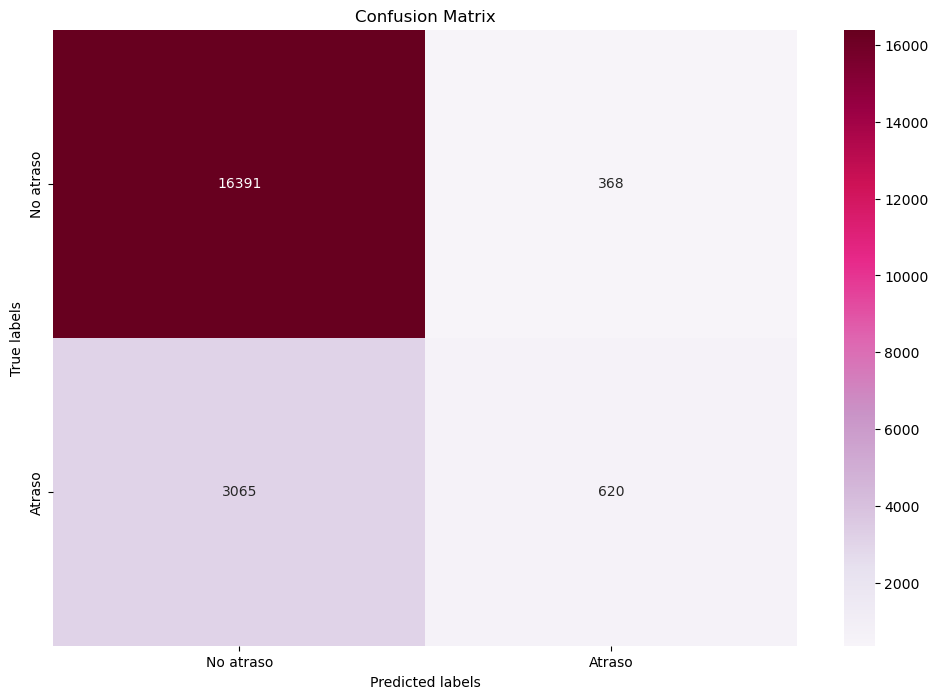

In [62]:
get_model_performance_test_set('cm_unbalanced', y_test, y_pred)

In [63]:
save_simple_metrics_report('report_unbalanced', train_score_mean, test_score_mean, validation_score, report, pipe)

## Camino 2.0 - balanceando el dataset (sub-muestreo)

In [64]:
# leemos el dataset de training
data_train = pd.read_csv(path.data_processed_dir('data_train.csv'))

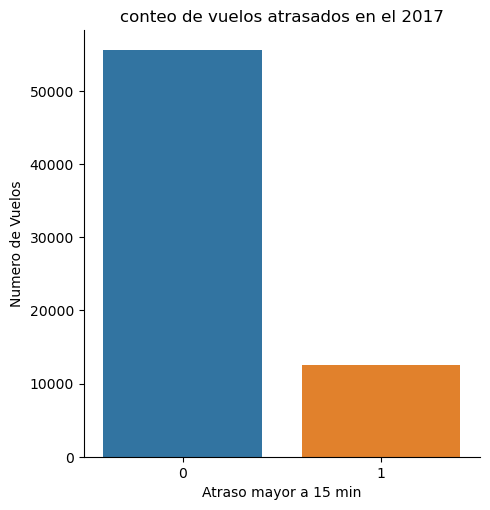

In [65]:
sns.catplot(
    data= data_train,
    x='atraso_15',
    kind='count',
)
plt.xlabel('Atraso mayor a 15 min')
plt.ylabel('Numero de Vuelos')
plt.title('conteo de vuelos atrasados en el 2017')
plt.show()

In [66]:
data_train['atraso_15'].value_counts()

0    55550
1    12596
Name: atraso_15, dtype: int64

In [67]:
data = pd.concat(
    [data_train[data_train['atraso_15']==0].sample(12596),data_train[data_train['atraso_15']==1]]
)

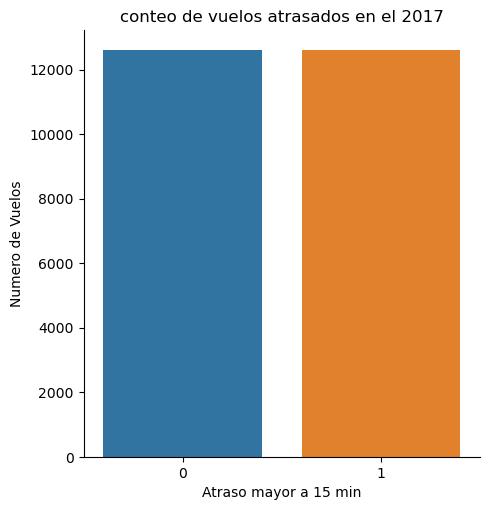

In [68]:
sns.catplot(
    data= data,
    x='atraso_15',
    kind='count',
)
plt.xlabel('Atraso mayor a 15 min')
plt.ylabel('Numero de Vuelos')
plt.title('conteo de vuelos atrasados en el 2017')
plt.show()

In [69]:
# Dividir los datos en variables de entrada y salida
X = data.drop('atraso_15', axis=1)
y = data['atraso_15']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [70]:
# entrenamos y evaluamos diferentes modelos
pipelines, scores_df = modelPipeline(X_train, X_test, y_train, y_test)
scores_df

/home/frandak2/latam_airlines/latam_airlines/utils/latam_utils.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({
/home/frandak2/latam_airlines/latam_airlines/utils/latam_utils.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({
/home/frandak2/latam_airlines/latam_airlines/utils/latam_utils.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({
/home/frandak2/latam_airlines/latam_airlines/utils/latam_utils.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({
/home/frandak2/latam_airlines/latam_airlines/utils/l

,Model,F1_Score,Precision,Recall,Accuracy
0,Logistic Regression,0.633491,0.633488,0.633501,0.633501
1,MLP,0.622058,0.622832,0.622255,0.622255
2,Decision Tree,0.616783,0.617078,0.616830,0.616830
3,Random Forest,0.646731,0.646730,0.646732,0.646732
4,XGBoost,0.663013,0.663049,0.663006,0.663006


In [71]:
# Crear una pipeline que incluya el ColumnTransformer y el XGBClassifier
# Crear un objeto ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler( with_mean=False), ['DIA', 'MES', 'HORA', 'MIN','Vlo_change', 'Emp_change','temporada_alta']),
        ('cat-nominal', OneHotEncoder(), ['periodo_dia','DIANOM', 'MESNOM','Des_I', 'TIPOVUELO', 'OPERA'])
    ],
    )
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',XGBClassifier(**rs))
    ]
)

# realizar validacion cruzada
final_result = cross_validate(pipe, X_train, y_train, return_train_score=True, cv=5)
#observamos la dispersion del score
train_score_std = np.std(final_result['train_score'])
test_score_std = np.std(final_result['test_score'])
print('Dispersion del score en la validacion cruzada')
print(f'Dispersion train score: {train_score_std}')
print(f'Dispersion test score: {test_score_std}')

# Observamos la media del score
train_score_mean = np.mean(final_result['train_score'])
test_score_mean = np.mean(final_result['test_score'])
print('media del score en la validacion cruzada')
print(f'media train score: {train_score_mean}')
print(f'media test score: {test_score_mean}')

# Entrenar modelo
pipe.fit(X_train, y_train)
# Mostrar los resultados

validation_score =pipe.score(X_test, y_test)

y_pred = pipe.predict(X_test)

# Imprimiendo el reporte de clasificación
report = classification_report(y_test, y_pred)
print(report)

Dispersion del score en la validacion cruzada
Dispersion train score: 0.0016393191920711148
Dispersion test score: 0.007233352935463822
media del score en la validacion cruzada
media train score: 0.7873851343017337
media test score: 0.6634340291352617
              precision    recall  f1-score   support

           0       0.67      0.66      0.66      3814
           1       0.66      0.66      0.66      3744

    accuracy                           0.66      7558
   macro avg       0.66      0.66      0.66      7558
weighted avg       0.66      0.66      0.66      7558



Se puede concluir lo siguiente:

- Para la clase 0 (no atraso), el 67% de los casos clasificados como no atrasados son realmente no atrasados.
- Para la clase 0 (no atraso), el 66% de los casos reales de no atraso son identificados correctamente por el modelo.
- Para la clase 1 (atraso), el 66% de los casos clasificados como atrasados son realmente atrasados.
- Para la clase 1 (atraso), el 67% de los casos reales de atraso son identificados correctamente por el modelo.
- El accuracy general del modelo es de 0.67, lo que significa que el modelo predice correctamente el 67% de las veces en promedio.

En este caso, se podría considerar hacer un over-sampling del modelo para mejorar su desempeño en la clasificación de las clases.

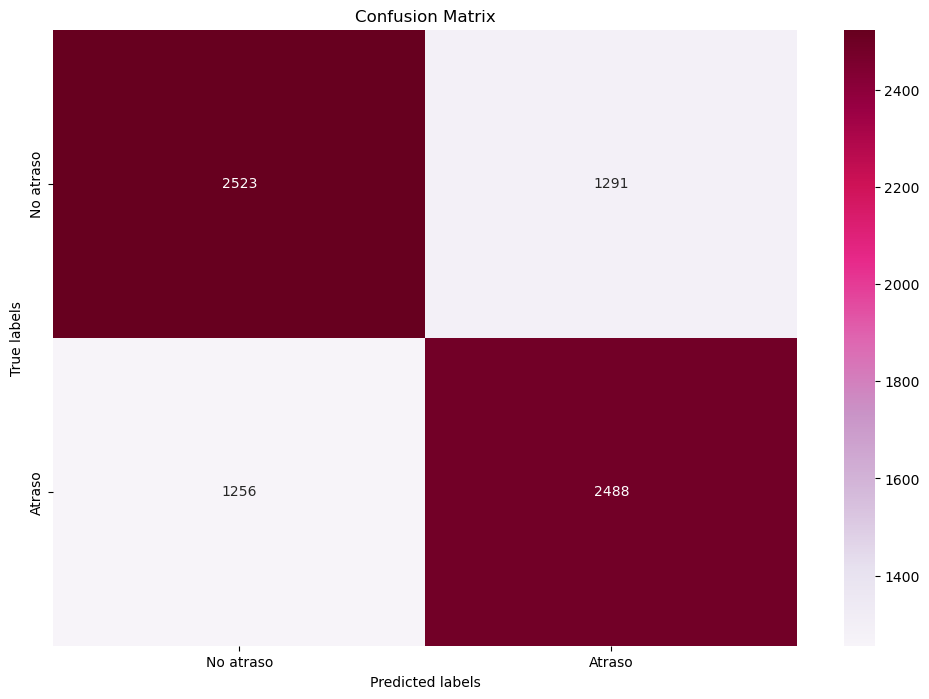

In [72]:
get_model_performance_test_set('cm_balanced_sub', y_test, y_pred)

In [73]:
save_simple_metrics_report('report_balanced_sub', train_score_mean, test_score_mean, validation_score, report, pipe)
update_model('model_balanced_sub',pipe)

## Camino 2.1 - balanceando el dataset (sobre-muestreo)
### Creacion de Data aumentation

In [74]:
# Importar las librerías necesarias
import latam_airlines.utils.paths as path
from latam_airlines.utils.latam_utils import check_quality

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [75]:
# leemos el dataset de training
data_train = pd.read_csv(path.data_processed_dir('data_train.csv'))
# Obtiene las características y la variable objetivo
X = data_train.drop("atraso_15", axis=1)
y = data_train["atraso_15"]

# Crear una pipeline que incluya el ColumnTransformer
# Crear un objeto ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler( with_mean=False), ['DIA', 'MES', 'HORA', 'MIN','Vlo_change', 'Emp_change','temporada_alta']),
        ('cat-nominal', OneHotEncoder(), ['periodo_dia','DIANOM', 'MESNOM','Des_I', 'TIPOVUELO', 'OPERA'])
    ],
    )

#transformar datos
X_transform = preprocessor.fit_transform(X)

# Aplica SMOTE para generar datos sintéticos
smote = SMOTE(sampling_strategy='minority',random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transform, y)

# Inversión de la transformación de escalamiento
scaler = preprocessor.named_transformers_['num']
X_scaled = scaler.inverse_transform(X_resampled[:, :7])

# Inversión de la transformación One-hot
onehot = preprocessor.named_transformers_['cat-nominal']
X_onehot = X_resampled[:, 7:]
X_original = onehot.inverse_transform(X_onehot)

# Concatena los valores originales y convierte el resultado en un DataFrame
X_recovered = np.concatenate([X_scaled.toarray().astype(int), X_original], axis=1)

In [76]:
data_train_balanced = pd.DataFrame(X_recovered, columns=X.columns)
data_train_balanced["atraso_15"] = y_resampled

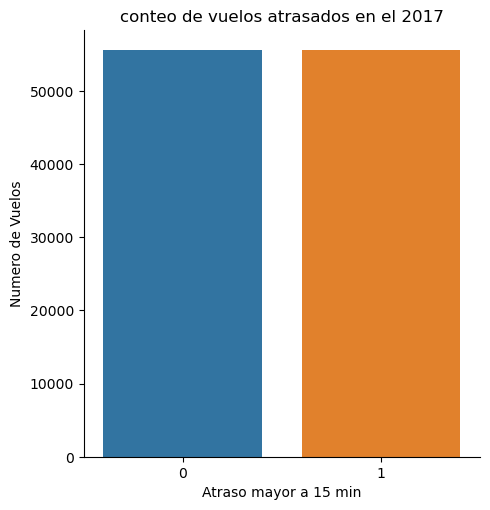

In [77]:
sns.catplot(
    data= data_train_balanced,
    x='atraso_15',
    kind='count',
)
plt.xlabel('Atraso mayor a 15 min')
plt.ylabel('Numero de Vuelos')
plt.title('conteo de vuelos atrasados en el 2017')
plt.show()

In [78]:
check_quality(data_train_balanced)

Valores NA por columna:
DIA               0
MES               0
HORA              0
MIN               0
Vlo_change        0
Emp_change        0
temporada_alta    0
periodo_dia       0
DIANOM            0
MESNOM            0
Des_I             0
TIPOVUELO         0
OPERA             0
atraso_15         0
dtype: int64

Cantidad de datos duplicados:
13134

Valores únicos por columna:
DIA               31
MES               12
HORA              24
MIN               60
Vlo_change         2
Emp_change         2
temporada_alta     2
periodo_dia        3
DIANOM             7
MESNOM            12
Des_I             52
TIPOVUELO          2
OPERA             23
atraso_15          2
dtype: int64


In [79]:
data_train_balanced.drop_duplicates(inplace=True)

In [80]:
# Guarda el dataset balanceado en un archivo
data_train_balanced.to_csv(path.data_processed_dir('data_train_balanced.csv'), index=False)

In [81]:
data_train_balanced = pd.read_csv(path.data_processed_dir('data_train_balanced.csv'))

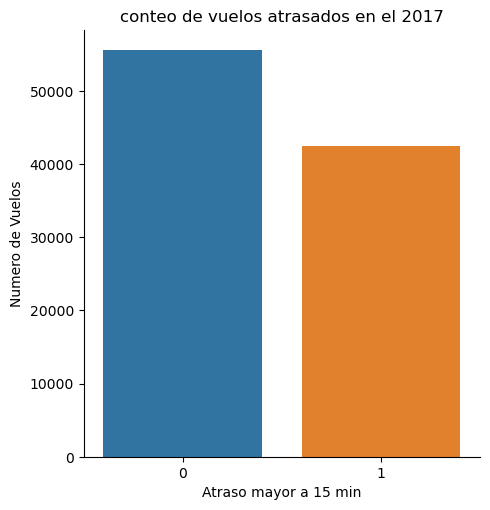

In [82]:
sns.catplot(
    data= data_train_balanced,
    x='atraso_15',
    kind='count',
)
plt.xlabel('Atraso mayor a 15 min')
plt.ylabel('Numero de Vuelos')
plt.title('conteo de vuelos atrasados en el 2017')
plt.show()

In [83]:
# Dividir los datos en variables de entrada y salida
X = data_train_balanced.drop('atraso_15', axis=1)
y = data_train_balanced['atraso_15']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [84]:
pipelines, scores_df = modelPipeline(X_train, X_test, y_train, y_test)
scores_df

/home/frandak2/latam_airlines/latam_airlines/utils/latam_utils.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({
/home/frandak2/latam_airlines/latam_airlines/utils/latam_utils.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({
/home/frandak2/latam_airlines/latam_airlines/utils/latam_utils.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({
/home/frandak2/latam_airlines/latam_airlines/utils/latam_utils.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({
/home/frandak2/latam_airlines/latam_airlines/utils/l

,Model,F1_Score,Precision,Recall,Accuracy
0,Logistic Regression,0.636317,0.644494,0.647873,0.647873
1,MLP,0.741863,0.741842,0.741885,0.741885
2,Decision Tree,0.787859,0.790259,0.787138,0.787138
3,Random Forest,0.863202,0.864746,0.862810,0.862810
4,XGBoost,0.776932,0.782733,0.780606,0.780606


Como lo mencione anteriormente se escoge el modelo que mejor metricas tienen, aca demebmos tomar en cuenta que el modelo de RandomForestClassifier es algo pesado si lo consideramos para el paso a produccion.

In [85]:
# Crear una pipeline que incluya el ColumnTransformer y el RandomForestClassifier
# Crear un objeto ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler( with_mean=False), ['DIA', 'MES', 'HORA', 'MIN','Vlo_change', 'Emp_change','temporada_alta']),
        ('cat-nominal', OneHotEncoder(), ['periodo_dia','DIANOM', 'MESNOM','Des_I', 'TIPOVUELO', 'OPERA'])
    ],
    )
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',RandomForestClassifier(**rs))
    ]
)

# realizar validacion cruzada
final_result = cross_validate(pipe, X_train, y_train, return_train_score=True, cv=5)
#observamos la dispersion del score
train_score_std = np.std(final_result['train_score'])
test_score_std = np.std(final_result['test_score'])
print('Dispersion del score en la validacion cruzada')
print(f'Dispersion train score: {train_score_std}')
print(f'Dispersion test score: {test_score_std}')

# Observamos la media del score
train_score_mean = np.mean(final_result['train_score'])
test_score_mean = np.mean(final_result['test_score'])
print('media del score en la validacion cruzada')
print(f'media train score: {train_score_mean}')
print(f'media test score: {test_score_mean}')


# Entrenar modelo
pipe.fit(X_train, y_train)

# Mostrar los resultados
validation_score =pipe.score(X_test, y_test)
y_pred = pipe.predict(X_test)

# Imprimiendo el reporte de clasificación
report = classification_report(y_test, y_pred)
print(report)

Dispersion del score en la validacion cruzada
Dispersion train score: 5.07795314292615e-05
Dispersion test score: 0.0011902642810193858
media del score en la validacion cruzada
media train score: 0.9991651596764388
media test score: 0.8428167300268654
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     16682
           1       0.82      0.87      0.85     12708

    accuracy                           0.86     29390
   macro avg       0.86      0.86      0.86     29390
weighted avg       0.86      0.86      0.86     29390



Se puede concluir lo siguiente:

- Para la clase 0 (no atraso), el 89% de los casos clasificados como no atrasados son realmente no atrasados.
- Para la clase 0 (no atraso), el 86% de los casos reales de no atraso son identificados correctamente por el modelo.
- Para la clase 1 (atraso), el 82% de los casos clasificados como atrasados son realmente atrasados.
- Para la clase 1 (atraso), el 86% de los casos reales de atraso son identificados correctamente por el modelo.
- El accuracy general del modelo es de 0.86, lo que significa que el modelo predice correctamente el 86% de las veces en promedio.

Podriamos hacer tuning de los hiperparametros de RandomForest, pero este resultado es satisfactorio.

Procedemos a guardar nuestro modelo y sus metricas

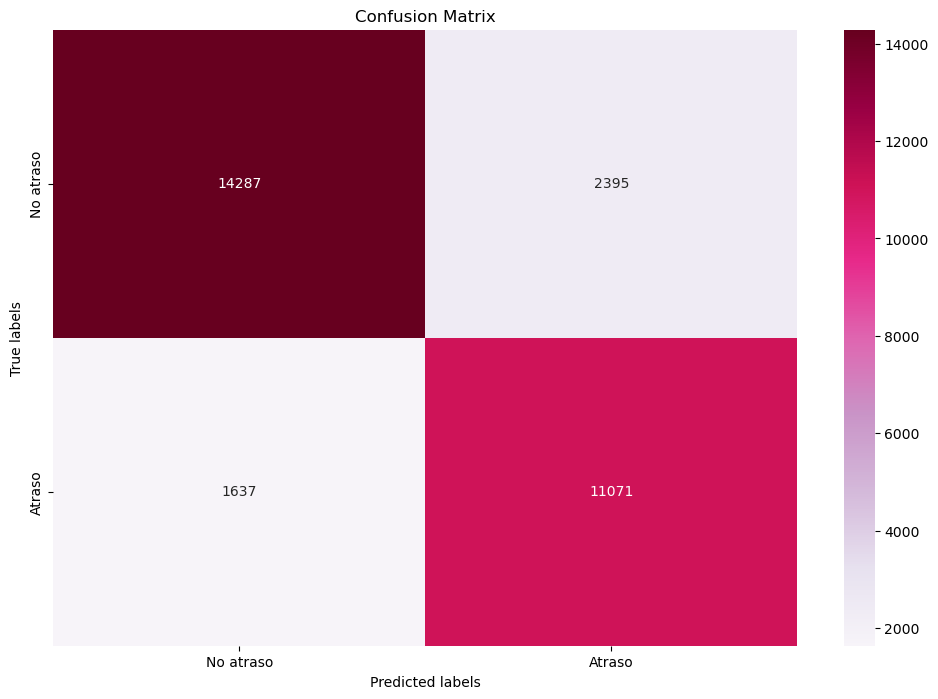

In [86]:
get_model_performance_test_set('cm_balanced_over', y_test, y_pred)

In [87]:
save_simple_metrics_report('report_balanced_over', train_score_mean, test_score_mean, validation_score, report, pipe)
update_model('model_balanced_over',pipe)

### Validaremos con los datos reales usando las mismas metricas

In [89]:
# leemos el dataset de training
data_train = pd.read_csv(path.data_processed_dir('data_train.csv'))

In [90]:
# Dividir los datos en variables de entrada y salida
X = data_train.drop('atraso_15', axis=1)
y = data_train['atraso_15']

In [91]:
from latam_airlines.utils.latam_utils import get_model

In [92]:
pipe = get_model('model_balanced_sub.pkl')
y_pred = pipe.predict(X)

# Imprimiendo el reporte de clasificación
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.68      0.78     55550
           1       0.34      0.74      0.47     12596

    accuracy                           0.69     68146
   macro avg       0.63      0.71      0.62     68146
weighted avg       0.81      0.69      0.72     68146



A pesar de que el modelo entrenado con sub-muestreo tiene un desempenio aceptable vemos que la precision a la hora de predecir el retraso de un vuelo no es eficiente

In [93]:
pipe = get_model('model_balanced_over.pkl')
y_pred = pipe.predict(X)

# Imprimiendo el reporte de clasificación
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     55550
           1       0.82      0.92      0.87     12596

    accuracy                           0.95     68146
   macro avg       0.90      0.94      0.92     68146
weighted avg       0.95      0.95      0.95     68146



### Concluimos
- El modelo entrenado con sobre-muestreo o creacion de datos sinteticos tiene el mejor desempenio
- La precision y el recall estan balanceadas y altas
- Un buen PR significa que el modelo tiene una buena precision y exactitud con datos no visto en su entrenamiento, osea es eficiente a la hora de predecir el retraso de un vuelo.
- Por ultim como deseamos obtener las probabilidades usamos la funcion .predict_proba la cual regresa la probabilidad de atraso o no de un vuelo

Como se comportaria el modelo solo con datos del operador LATAM?

In [94]:
data_LATAM = data_train[data_train['OPERA']=='Grupo LATAM']

In [95]:
# Dividir los datos en variables de entrada y salida
X = data_LATAM.drop('atraso_15', axis=1)
y = data_LATAM['atraso_15']

In [96]:
pipe = get_model('model_balanced_over.pkl')
y_pred = pipe.predict(X)

# Imprimiendo el reporte de clasificación
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     33551
           1       0.81      0.92      0.86      7289

    accuracy                           0.95     40840
   macro avg       0.90      0.94      0.92     40840
weighted avg       0.95      0.95      0.95     40840



Se puede concluir lo siguiente  para el operador LATAM:

- El modelo clasifica el 98% de los casos como no atrasados y son realmente no atrasados.
- El modelo clasifica correctamente el 86% de los casos reales de no atraso.
- El modelo clasifica el 82% de los casos clasificados como atrasados y son realmente atrasados.
- El modelo clasifica correctamente el 86% de los casos reales de atraso.
- El accuracy general del modelo es de 0.86, lo que significa que el modelo predice correctamente el 86% de las veces en promedio.

En otras palabras, el modelo hubiese podido alertar el 82% de los atrasos del grupo LATAM en el aeropuerto SCL del 2017.

### Importancia de las Features en el modelo

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from latam_airlines.utils.latam_utils import get_model
import latam_airlines.utils.paths as path

In [98]:
pipe = get_model('model_balanced_over.pkl')

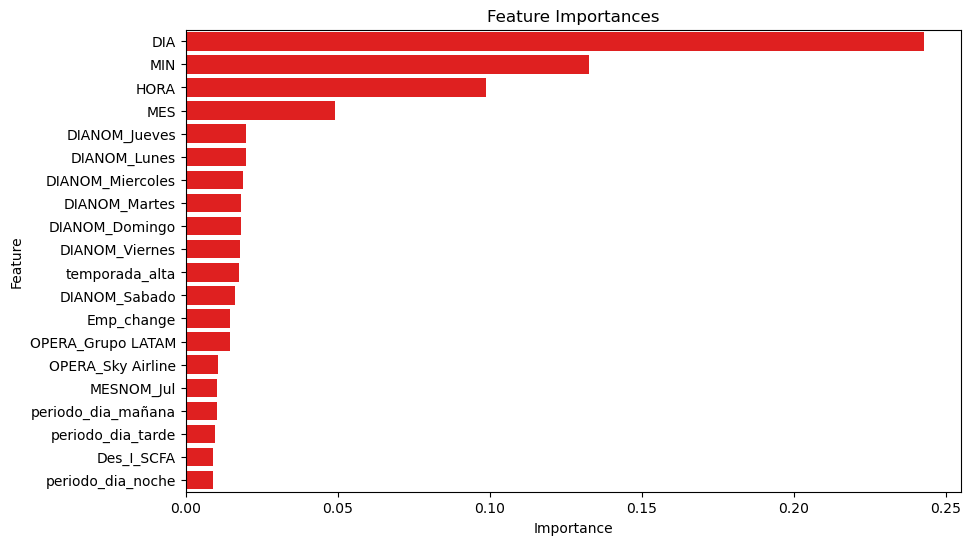

In [99]:
feature_names = pipe['preprocessor'].get_feature_names_out()
feature_names = list(map(lambda x: x.split('__'), feature_names))
feature_names = [elem[1] for elem in feature_names]

# create a DataFrame with feature names and importances
feature_importances = pd.DataFrame(zip(feature_names, pipe['model'].feature_importances_), columns=['feature', 'importance'])

# sort features by importance in descending order
feature_importances = feature_importances.sort_values('importance', ascending=False)

# plot feature importances using a horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20), color='red')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [100]:
feature_importances['importance'].head(5).sum()

0.5431227439376968

# Concluimos
el top 5 de las caracteristicas de mayor peso reune el 55% de la explicacion del modelo el top 5 son el dia, minuto, hora, mes y nombre del dia(lunes), esto significando que la fecha hasta el minuto tien un gran peso en el modelo dando luces de que se puede afrontar el modelo como series de tiempo. 